In [1]:
# Importing all the necessary modules
import os                                   # OS specific module
    
import torch                                # PyTorch main module 
import torch.nn as nn                       # Neural network PyTroch module
import torch.utils.data as Data             # Dataset PyTorch module

import torchvision                          # Computer vision PyTorch module
import torchvision.transforms as transforms # Image transform PyTorch module

In [2]:
torch.manual_seed(1)                        # Adjusting random generator

In [3]:
# Creating the model of our CNN:
class CNN( nn.Module ):
    def __init__( self ):
        super( CNN, self ).__init__()
        self.conv1 = nn.Sequential(                   # First layer. Input: 3 channel image (RGB)
                                                      # with size 32х32 or (3, 32, 32) 
            nn.Conv2d(                                # Convolution function.  
                in_channels  = 3                      # Input channels: 3, equals the input image channels
              , out_channels = 16                     # Output channels: 16
              , kernel_size  = 5                      # Kernel size: 5
              , stride       = 1                      # Vertical and Horizontal stride: 1
              , padding      = 2                      # Padding: 2
            )
            , nn.ReLU()                               # Activation function: ReLU
            , nn.MaxPool2d( kernel_size = 2
                          , dilation    = 1)          # Pooling function with kernel size: 2
        )                                             # Output image: ( 16, 16, 16 )  
        
        self.conv2 = nn.Sequential(                   # Second layer. Imput image: ( 16, 16, 16 )
              nn.Conv2d( 16, 32, 5, 1, 2 )            # Convolution function.
            , nn.ReLU()                               # Activation function.
            , nn.MaxPool2d( kernel_size = 2, dilation    = 1 )         # Pooling function. 
            , nn.Dropout2d( p = 0.2 )               
         
        )                                             # Output image: ( 32, 8, 8 )
        
        self.out = nn.Linear( 32 * 8 * 8, 10 )        # Fully connected layer. First argument: Input
                                                      # array size. Second: amount of outputs (equals
                                                      # amount of classes)
    def forward( self, x ):                           # Reimplementing method forward of superclass
                                                      # nn.Module
        x = self.conv1(x)                             # Calling first layer.
        x = self.conv2(x)                             # Calling second layer.
        x = x.view( x.size(0), -1 )                   # Squeezing into 1-d array
        x = self.out(x)                               # Form perceptron
        return x                                      # Return the result

In [4]:
cnn = CNN()                                           # Create CNN-type object
print(cnn)                                            # Output CNN architecture as text

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.2)
  )
  (out): Linear(in_features=2048, out_features=10, bias=True)
)


In [5]:
# Create IPL to Tensor transform function
transform = transforms.Compose( [ 
        transforms.ToTensor()
      , transforms.Normalize( ( 0.5,0.5, 0.5 ), ( 0.5, 0.5, 0.5 ) ) 
    ]
)

train_data = torchvision.datasets.CIFAR10(            # Download dataset Cifar10 from
                                                      # https://www.cs.toronto.edu/~kriz/cifar.html
      root      = './cifar10/'                        # Dataset path
    , train     = True                                # If True, data will be used to train
                                                      # False - to test
    , transform = transform                           # IPL to Tensor transform function.
    , download  = True                                # If True, data will be downloaded from repository, 
                                                      # False - use local data
)

Files already downloaded and verified


In [6]:
train_loader = Data.DataLoader(                       # Create Data.DataLoader type object
      dataset    = train_data                         # Input dataset'a - train_data
    , batch_size = 50                                 # How many image will be used to train at one go
    , shuffle    = True                               # Do we need to shuffle dataset?
)

In [7]:
# Create optimizer object (in our particular case, Adam optimizer).
# Input CNN parameters and learning rate
optimizer = torch.optim.Adam( cnn.parameters(), lr = 0.001 )  

# Define loss function (Cross Entropy)
loss_func = nn.CrossEntropyLoss()

In [8]:
# Train the CNN

MAX_EPOCH = 1                                                          # Number of iterations for training.
                                                                       # Insert your number here
running_loss = 0.0
for epoch in range( MAX_EPOCH ):
    for step, ( b_images, b_labels ) in enumerate( train_loader ):    # For all images b_images and labels b_labels 
        output = cnn( b_images )                                      # get the results of CNN to output
        loss   = loss_func( output, b_labels )                        # Calculate the loss between output
                                                                      # and known labels b_labels
        optimizer.zero_grad()                                         # Zero gradient
        loss.backward()                                               # Using backpropagation
        optimizer.step()                                              # Applying gradient
        
        running_loss += loss.item()                                   # Get the loss on current step
        if step % 100 == 99:
            print( '[%d, %5d] loss: %f' % ( epoch, step, running_loss / 100) )  # Output the loss
            running_loss = 0.0                                                  # Zero the loss

[0,    99] loss: 1.981902
[0,   199] loss: 1.661853
[0,   299] loss: 1.556734
[0,   399] loss: 1.482239
[0,   499] loss: 1.433049
[0,   599] loss: 1.423994
[0,   699] loss: 1.378161
[0,   799] loss: 1.290709
[0,   899] loss: 1.302554
[0,   999] loss: 1.261217


In [9]:
# Download testing dataset
test_data = torchvision.datasets.CIFAR10(
      root = './cifar10/'
    , train     = False
    , download  = True
    , transform = transform
)

BATCH_SIZE = 4

test_loader = torch.utils.data.DataLoader(
      test_data
    , batch_size = BATCH_SIZE
    , shuffle    = True
    , num_workers = 2                      # How many processes will be used for testing
)

Files already downloaded and verified


In [10]:
# Write the util for image output.

import numpy as np
import matplotlib.pyplot as plt

def imshow( img ):
    img   = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow( np.transpose( npimg, (1, 2, 0) ) )

GroundTruth:  truck airplane frog ship


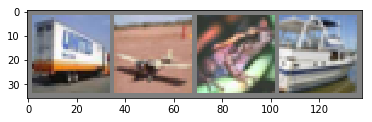

In [11]:
# Define class name vector
classes   = ( 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck' )
# Define dataset iterator
data_iter = iter( test_loader )
# Get the images and labels from dataset.
images, labels = data_iter.next()
# Output image
imshow( torchvision.utils.make_grid( images ) ) 
# Output corresponding classes
print( 'GroundTruth: ', ' '.join( '%s' % classes[labels[j]] for j in range( BATCH_SIZE ) ))

In [12]:
# Run our CNN on BATCH_SIZE images from dataset
outputs = cnn( images )
_, predicted = torch.max( outputs, 1 )
print( "Predicted: ", ' '.join( '%s' % classes[predicted[j]] for j in range ( BATCH_SIZE ) ) )

Predicted:  truck truck frog ship


In [ ]:
# Write function for error estimation of our classification

class_correct = list( 0. for i in range(10) )                     # Define zero vector of size 10
                                                                  # (number of classes)
class_total   = list( 0. for i in range(10) )
with torch.no_grad():                                             # Do not use gradient
    for data in test_loader:                                      # For each data in dataset
        images, labels = data                                     # Get image and label
        outputs = cnn( images )                                   # Apply CNN to image
        _, predicted = torch.max( outputs, 1 )                    
        c = ( predicted == labels ).squeeze()
        for i in range( BATCH_SIZE ):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1

In [ ]:
for i in range(10):
    print( 'Accuracy of %s : %d %%' % (classes[i], 100 * class_correct[i] / class_total[i] ) )
